This notebook walks through a few examples that show how to use `triceratops`. The examples below show:

1. How to apply `triceratops` on a star observed in a $\textbf{single}$ ${\it Kepler}$ quarter $\textbf{without}$ follow up data.

In [1]:
import numpy as np
import pandas as pd
import time
from lightkurve import KeplerLightCurve
import matplotlib.pyplot as plt
import triceratops.triceratops as tr
import sys

%matplotlib inline
print(sys.version)

import warnings
warnings.filterwarnings('ignore')

3.8.11 (default, Aug  3 2021, 15:09:35) 
[GCC 7.5.0]


## Example initialization

First, let's apply the tool on Kepler-10b (KIC 11904151), the first terrestrial planet discovered by Kepler (https://ui.adsabs.harvard.edu/abs/2011ApJ...729...27B/abstract).

Begin by defining the target star object with the `target(ID, sectors)` class. The arguments for this class are `ID` (the KIC ID of the star) and `sectors` (the quarters in which the star was observed). `ID` should be an integer and `sectors` should be a numpy array.

We'll use quarter 3 for this example, although any combination of quarters would be valid.

In [2]:
ID = 11904151
sectors = np.array([3])
target = tr.target(ID=ID, sectors=sectors, mission="Kepler")

Next, let's define the aperture used to extract the light curve, plot an image of the field, and display a table of nearby stars.

The aperture should be a 2D numpy array with the formal `[[col#, row#], [col#, row#], [col#, row#], ...]`, where where each `[col#, row#]` is the column and row number of the pixel.

An image of the field can be plotted with the `.plot_field(sector, ap_pixels)` method. This method takes as optional arguments `sector` (the image sector you would like to plot) and `ap_pixels` (the aperture we just defined).

We can display a table of the stars in the image with the `.stars` attribute. This table contains the separation and position angle of each star from the target star, so that each can be identified in the plot. Note that the "ID" column lists the TIC ID of each star, not the KIC ID.

Note that the scale of a TESS pixel is about 20 arcseconds and a Kepler/K2 pixel is about 4.

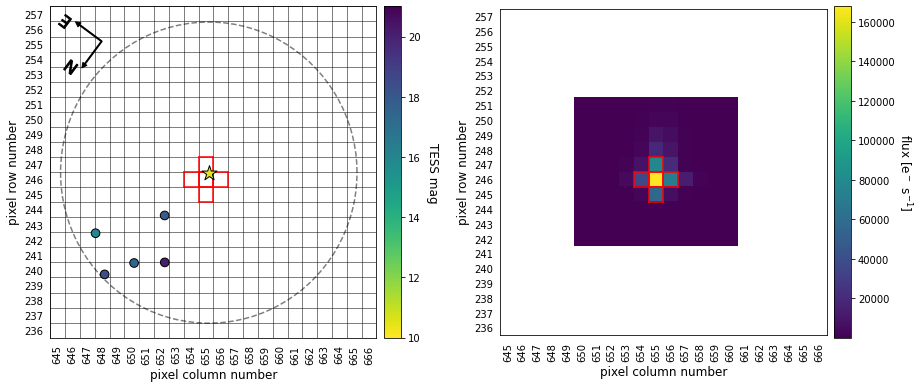

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N)
0,377780790,10.4767,9.889,9.563,9.496,285.679422,50.241306,1.017,1.089740,5706.0,5.361850,0.000,0.000
1,1717218059,17.8806,NaN,NaN,NaN,285.680619,50.245790,1.070,0.809877,5895.0,-0.111711,16.375,9.693
2,1717218056,20.0671,NaN,NaN,NaN,285.677382,50.248546,NaN,NaN,NaN,0.879011,26.486,349.788
3,1717218060,17.4027,NaN,NaN,NaN,285.680220,50.249945,1.030,1.055070,5771.0,-0.004017,31.154,3.380
4,377780779,15.8564,14.727,14.117,14.075,285.685892,50.249906,0.700,0.804521,4467.0,0.999995,34.356,25.690
5,1717218057,18.4788,NaN,NaN,NaN,285.682207,50.251926,NaN,NaN,4923.0,0.325102,38.767,9.518


In [4]:
ap = np.array([            [655, 247],
               [654, 246], [655, 246], [656, 246],
                           [655, 245]             ])

target.plot_field(sector=3, ap_pixels=ap)
 
target.stars

We can now determine which stars in the aperture are bright enough to produce the observed transit. The transit for this TOI has a depth of ~190 ppm. We'll use the `.calc_depths(tdepth, all_ap_pixels)` method to do this. This method takes as arguments `tdepth` (the transit depth of the candidate) and `all_ap_pixels` (a numpy array of all apertures). After doing this, the `.stars` table includes the flux ratio contributed by each star in the aperture and the transit depth each star would have if it were the host of the signal.

In [5]:
apertures = np.array([ap])
target.calc_depths(tdepth=0.00019, all_ap_pixels=apertures)
target.stars

,ID,Tmag,Jmag,Hmag,Kmag,ra,dec,mass,rad,Teff,plx,sep (arcsec),PA (E of N),fluxratio,tdepth
0,377780790,10.4767,9.889,9.563,9.496,285.679422,50.241306,1.017,1.089740,5706.0,5.361850,0.000,0.000,9.999993e-01,0.00019
1,1717218059,17.8806,NaN,NaN,NaN,285.680619,50.245790,1.070,0.809877,5895.0,-0.111711,16.375,9.693,6.626514e-07,0.00000
2,1717218056,20.0671,NaN,NaN,NaN,285.677382,50.248546,NaN,NaN,NaN,0.879011,26.486,349.788,1.308192e-14,0.00000
3,1717218060,17.4027,NaN,NaN,NaN,285.680220,50.249945,1.030,1.055070,5771.0,-0.004017,31.154,3.380,4.187665e-19,0.00000
4,377780779,15.8564,14.727,14.117,14.075,285.685892,50.249906,0.700,0.804521,4467.0,0.999995,34.356,25.690,2.692696e-22,0.00000
5,1717218057,18.4788,NaN,NaN,NaN,285.682207,50.251926,NaN,NaN,4923.0,0.325102,38.767,9.518,4.131923e-30,0.00000


After doing this, we can calculate the probability of each scenario using the `.calc_prob(time, flux_0, flux_err_0, P_orb)` method, which requires as arguments `time` (times from phase-folded light curve in units of days from transit center), `flux_0` (normalized flux from phase-folded light curve), `flux_err_0` (flux error values of the target's phase-folded light curve), and `P_orb` (orbital period of the TOI in days).

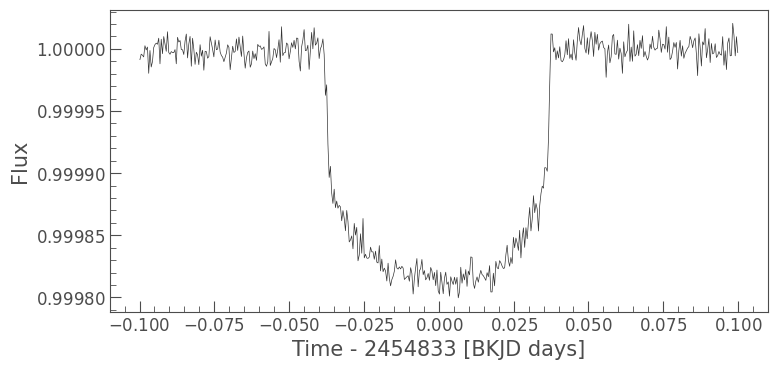

In [7]:
# read in the light curve
lc = pd.read_csv("Kepler10b_lightcurve.csv", header=None)
time, flux, flux_err = lc[0].values, lc[1].values, lc[2].values
P_orb = 0.837

mask = ~np.isnan(flux)
lc = KeplerLightCurve(time=time[mask], flux=flux[mask], flux_err=flux_err[mask])

lc.plot();

In [9]:
%%time

target.calc_probs(time=lc.time.value, flux_0=lc.flux.value, flux_err_0=np.mean(lc.flux_err.value), 
                  P_orb=P_orb, parallel=True)

Calculating TP, EB, and EBx2P scenario probabilities for 377780790.
Calculating PTP, PEB, and PEBx2P scenario probabilities for 377780790.
Calculating STP, SEB, and SEBx2P scenario probabilities for 377780790.
Calculating DTP, DEB, and DEBx2P scenario probabilities for 377780790.
Calculating BTP, BEB, and BEBx2P scenario probabilities for 377780790.
CPU times: user 4min 40s, sys: 50.1 s, total: 5min 30s
Wall time: 3min 47s


Now that that's done, let's check out a table of our results with the `.probs` attribute and calculate the false positive probability and nearby false positive probability using the `.FPP`  and `.NFPP` attributes. We expect a scatter of a few percent in our probabilities, so don't be alarmed if it's slightly different with each run. We can also plot the transit fits of each scenario using the `.plot_fits(time, flux_0, flux_err_0)` method.

In [10]:
df_results = target.probs
print("FPP =", target.FPP)
print("NFPP =", target.NFPP)
df_results

FPP = 8.359147213754525e-06
NFPP = 0.0


,ID,scenario,M_s,R_s,P_orb,inc,ecc,w,R_p,M_EB,R_EB,prob
0,377780790,TP,1.017000,1.089740,0.837,81.941887,0.137458,301.973062,1.530357,0.000000,0.000000,9.986258e-01
1,377780790,EB,1.017000,1.089740,0.837,62.306030,0.125414,155.004503,0.000000,0.902493,0.940614,0.000000e+00
2,377780790,EBx2P,1.017000,1.089740,1.674,79.804803,0.593447,271.445956,0.000000,0.969306,1.034376,0.000000e+00
3,377780790,PTP,1.017000,1.089740,0.837,83.379944,0.099257,339.859299,2.055697,0.000000,0.000000,1.322033e-03
4,377780790,PEB,1.017000,1.089740,0.837,60.451731,0.114222,122.593120,0.000000,0.953240,1.011065,0.000000e+00
5,377780790,PEBx2P,1.017000,1.089740,1.674,79.770569,0.620781,266.299544,0.000000,0.999198,1.078092,0.000000e+00
6,377780790,STP,0.951171,1.008085,0.837,83.692681,0.237393,326.519230,2.119661,0.000000,0.000000,8.359147e-06
7,377780790,SEB,0.109903,0.133778,0.837,73.517626,0.861199,10.740936,0.000000,0.017933,0.100000,0.000000e+00
8,377780790,SEBx2P,0.193797,0.224327,1.674,87.099013,0.827427,260.175941,0.000000,0.185594,0.216743,0.000000e+00
9,377780790,DTP,1.017000,1.089740,0.837,87.448863,0.505783,350.343154,1.475852,0.000000,0.000000,4.379518e-05


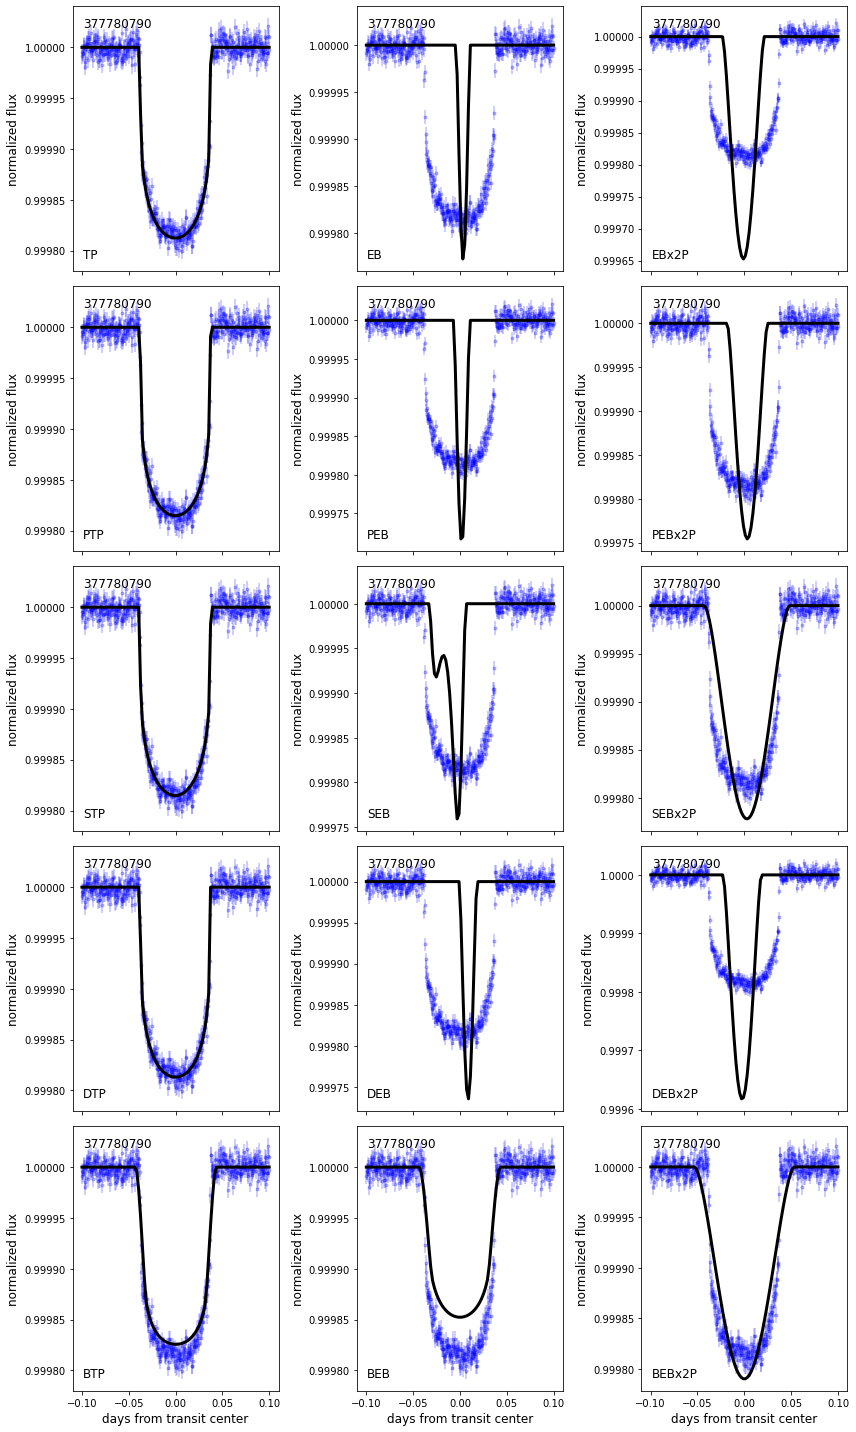

In [11]:
target.plot_fits(time=lc.time.value, flux_0=lc.flux.value, flux_err_0=np.mean(lc.flux_err.value))

TRICERATOPS predicts that this planet candidate is a bona fide planet with a radius of ~1.5 $R_\oplus$, which isn't too far off from the radius reported in the literature. With this FPP, the planet would be considered validated.